In [42]:
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

In [43]:
pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [44]:
spark = SparkSession.builder.master("local[2]").appName('car_accidents').getOrCreate()

In [45]:
df = spark.read.csv('C:/Users/a842488/OneDrive - Atos/Desktop/Project', inferSchema='True', header=True)
df = df.sample(0.1)

# Data Analysis

In [46]:
df.dtypes

[('ID', 'string'),
 ('Severity', 'int'),
 ('Start_Time', 'string'),
 ('End_Time', 'string'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('End_Lat', 'double'),
 ('End_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('Description', 'string'),
 ('Number', 'double'),
 ('Street', 'string'),
 ('Side', 'string'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Zipcode', 'string'),
 ('Country', 'string'),
 ('Timezone', 'string'),
 ('Airport_Code', 'string'),
 ('Weather_Timestamp', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean')

In [47]:
df.limit(5).toPandas().head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-6,2,2016-02-08 08:16:57,2016-02-08 14:16:57,39.063,-84.032,39.067,-84.059,1.427,At Dela Palma Rd - Accident.,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 08:16:00,35.6,29.2,100.0,29.66,10.0,WSW,8.1,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
1,A-7,2,2016-02-08 08:15:41,2016-02-08 14:15:41,39.776,-84.186,39.773,-84.188,0.227,At OH-4/Exit 54 - Accident.,NaN,I-75 S,R,Dayton,Montgomery,OH,45404,US,US/Eastern,KFFO,2016-02-08 08:18:00,33.8,NaN,100.0,29.63,3.0,SW,2.3,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-13,2,2016-02-08 17:27:39,2016-02-08 23:27:39,41.474,-81.704,41.474,-81.706,0.070,At US-42/Exit 170 - Accident.,NaN,I-90 E,R,Cleveland,Cuyahoga,OH,44113,US,US/Eastern,KBKL,2016-02-08 17:36:00,33.1,24.4,96.0,29.59,1.8,West,11.5,0.0,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,A-36,3,2016-02-09 10:07:49,2016-02-09 16:07:49,38.274,-85.748,38.286,-85.755,0.879,Between US-31/IN-62 and Stansifer Ave/Exit 1 - Accident.,NaN,I-65 S,R,Jeffersonville,Clark,IN,47130,US,US/Eastern,KLOU,2016-02-09 09:53:00,23.0,11.1,74.0,29.87,10.0,West,12.7,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-43,4,2016-02-09 18:20:58,2016-02-10 00:20:58,40.451,-85.150,40.354,-85.150,6.690,Closed between IN-26 and IN-67 - Road closed due to accident.,9001.0,W State Road 26,R,Dunkirk,Jay,IN,47336,US,US/Eastern,KMIE,2016-02-09 18:20:00,19.9,7.3,81.0,29.85,2.0,WNW,12.7,0.0,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day


In [48]:
# add new columns
df = df.withColumn('hour_of_accident', df.Start_Time.substr(12,2)) \
       .withColumn('date_of_accident', df.Start_Time.substr(1,10))

In [49]:
# create pivot table
distinct_states = [x.State for x in df.select('State').distinct().collect()]
df_county= df.groupBy('hour_of_accident').pivot('State',distinct_states).count().orderBy('hour_of_accident')

In [50]:
# create function to highlight the biggest value in each column
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [51]:
# wont be visible on git
df_county = df_county.toPandas().set_index('hour_of_accident')
df_county = df_county.fillna(0)
df_county = df_county.applymap('{:,.0f}'.format)
df_county.style.apply(highlight_max)

,SC,AZ,LA,MN,NJ,DC,OR,VA,RI,KY,WY,NH,MI,NV,WI,ID,CA,NE,CT,MT,NC,VT,MD,DE,MO,IL,ME,WA,ND,MS,AL,IN,OH,TN,IA,NM,PA,SD,NY,TX,WV,GA,MA,KS,CO,FL,AR,OK,UT
hour_of_accident,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00,298,151,150,240,132,9,268,266,5,9,3,8,99,26,14,20,"1,971",6,92,46,262,1,194,14,63,71,5,55,6,10,48,47,37,150,31,6,313,0,280,355,23,148,9,14,22,803,29,3,141
01,255,120,113,238,100,21,262,206,3,8,3,6,103,16,7,17,"1,740",3,63,46,172,0,157,11,51,98,1,52,3,18,49,37,40,116,24,3,284,0,235,321,17,87,6,15,29,597,32,5,92
02,254,127,93,201,82,12,267,219,5,6,0,7,88,11,10,16,"1,638",3,52,43,165,0,141,7,50,61,1,54,6,8,48,32,25,85,20,5,240,0,195,326,17,73,7,16,34,670,35,3,79
03,221,112,88,150,96,8,202,165,0,10,1,4,70,11,5,9,"1,382",4,39,25,137,0,113,5,42,55,1,55,6,4,26,45,33,87,19,3,187,1,206,274,11,79,6,6,32,645,21,6,57
04,176,117,108,169,101,20,216,192,1,4,3,2,69,4,9,10,"1,523",1,63,29,120,0,126,8,41,91,2,49,2,5,40,41,21,121,32,3,198,1,197,280,18,85,4,12,21,817,18,5,97
05,200,148,131,224,146,21,344,296,5,22,2,9,97,25,19,25,"2,444",4,75,49,196,0,207,10,64,135,3,97,8,11,51,67,35,135,26,11,270,0,373,482,20,117,17,18,49,"1,244",22,10,151
06,295,180,199,380,283,47,459,468,14,21,11,7,165,30,32,19,"3,125",11,118,75,282,2,291,16,123,226,7,166,7,20,67,105,93,203,36,14,352,0,464,719,22,194,34,33,125,"1,379",42,22,207
07,349,230,189,511,357,64,548,565,23,38,3,24,206,56,66,52,"3,595",30,153,82,426,3,335,20,202,273,17,161,8,29,108,138,159,253,46,22,402,0,554,804,31,236,51,58,157,"1,555",68,36,287
08,328,216,175,418,321,46,570,547,46,36,7,40,242,29,77,39,"3,357",33,144,87,463,2,316,15,181,310,28,161,9,36,80,126,157,230,55,21,346,1,533,689,35,227,51,51,147,"1,597",50,29,306


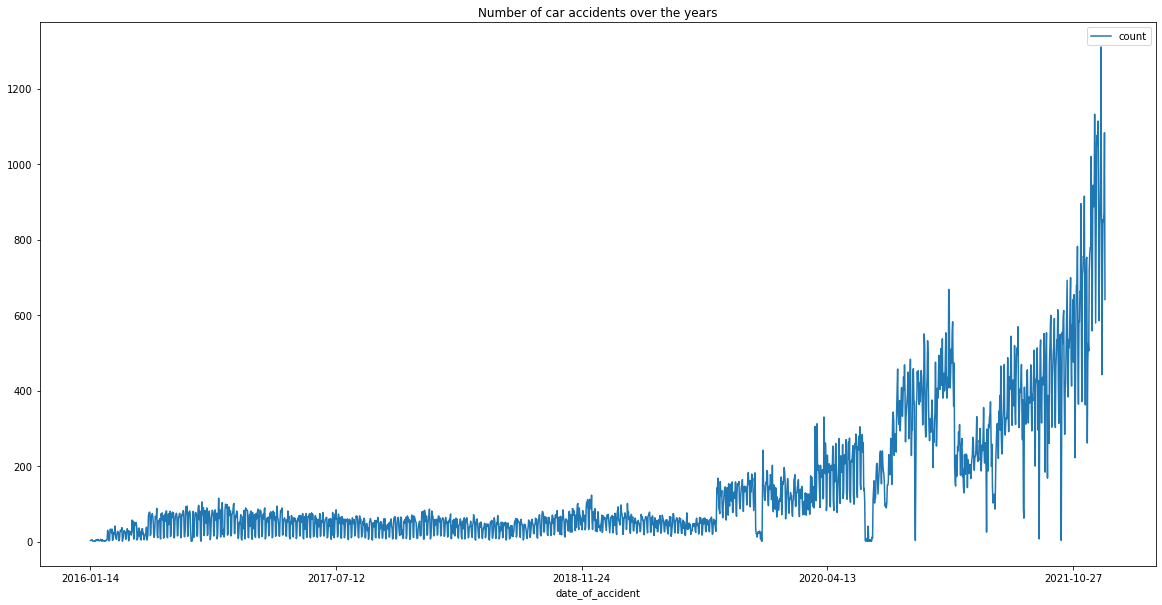

In [52]:
df_date = df.select('date_of_accident').groupBy('date_of_accident').count().orderBy('date_of_accident').toPandas()
df_date_chart = df_date.plot.line(title = 'Number of car accidents over the years', x='date_of_accident', figsize= (20,10))

In [53]:
# top 10 cities with car accidents
df_city = df.select('City').groupBy('City').count().orderBy(F.desc('count'))
df_city.toPandas().head(11)

,City,count
0,Miami,10847
1,Los Angeles,7082
2,Orlando,5385
3,Dallas,4182
4,Houston,3932
5,Charlotte,3195
6,Sacramento,3174
7,San Diego,2658
8,Raleigh,2337
9,Minneapolis,2246


In [111]:
df_model_test1 = df.select('date_of_accident','Temperature(F)').groupBy('date_of_accident') \
                   .count() \
                   .orderBy('date_of_accident')

df_model_test2 = df.select('date_of_accident','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)').groupBy('date_of_accident') \
                   .mean('Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)') \
                   .orderBy('date_of_accident') 

df_model = df_model_test1.join(df_model_test2, ['date_of_accident'])

In [112]:
df_model.limit(10).toPandas().head(2)

,date_of_accident,count,avg(Temperature(F)),avg(Wind_Chill(F)),avg(Humidity(%)),avg(Pressure(in)),avg(Visibility(mi)),avg(Wind_Speed(mph)),avg(Precipitation(in))
0,2016-08-17,68,77.037,NaN,71.809,30.038,9.052,7.889,0.22
1,2017-05-14,11,61.945,41.4,57.455,29.841,9.727,7.730,0.00


# After initial analysis lets try to predict the value of accidents for the next day based on the weather conditions etc.

In [ ]:
# use OneHotEncoder to convert categorical columns into vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

stringIndexer = [StringIndexer(inputCol=i, outputCol=i + "_index").fit(df_model).setHandleInvalid("keep") for i in categorical_columns]

encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="job_vec_"+indexer.getOutputCol()) for indexer in stringIndexer]

list_of_encoders = [encoder.getOutputCol() for encoder in encoders]
#list_of_encoders = [list_of_encoders.insert(0,i) for i in numerical_columns]

vector_assembler = VectorAssembler(inputCols=list_of_encoders, outputCol="features")

pipeline = Pipeline(stages = stringIndexer + encoders + [vector_assembler])
model = pipeline.fit(df_model)
df_model = model.transform(df_model)